---
title: "bias-variance tradeoff"
execute:
  # echo: false
  freeze: auto  # re-render only when source changes
format:
  html:
    code-fold: true
    code-summary: "Show the code"
---

Let's say I'm running an experiment where I observe some data points $(x, y)$. This experiment could represent whatevery you like, but I always like to have a concrete example in mind. Assume that $x$ is the number of years a person has gone to school/university, and $y$ is their income. The process that generates this data has a true underlying function $f(x)$, but I don't know what it is. What's worse, nature is noisy, so the observed data points $y$ are not exactly on the true function, but are spread around it:

$$
y = f(x) + \epsilon.
$$

Here the noise $\epsilon$ has zero mean and some standard deviation $\sigma$. In our example, the noise could represent all the other factors that affect a person's income, such as their family background, their social skills, their luck, and so on.

See below an example.

In [ ]:
#| code-summary: "import libraries"
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="ticks", font_scale=1.2)
import warnings
warnings.simplefilter('ignore', np.exceptions.RankWarning)
from numpy.polynomial import Chebyshev

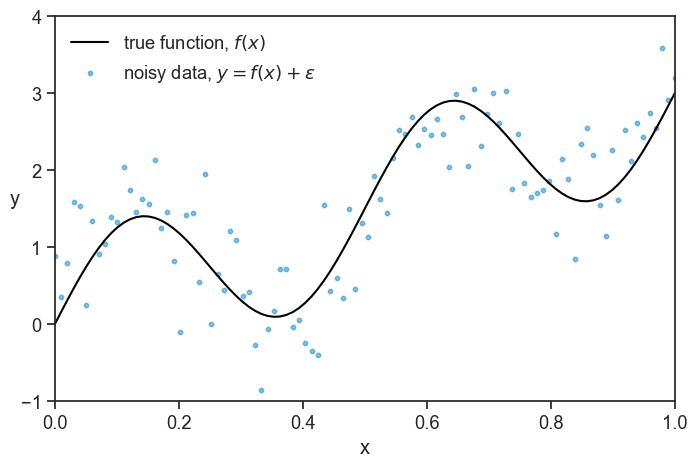

In [3]:
#| code-summary: "plot"
np.random.seed(0)
N = 100
f = lambda x: np.sin(4*np.pi*x) + 3*x
x_grid = np.linspace(0, 1, N)
blue = "xkcd:cerulean"
gold = "xkcd:gold"
pink = "xkcd:hot pink"

fig, ax = plt.subplots(figsize=(8, 5))
noise = np.random.normal(0, 0.5, size=N)
ax.plot(x_grid, f(x_grid), color='black', label=r'true function, $f(x)$')
ax.scatter(x_grid, f(x_grid) + noise, s=10, alpha=0.5, color=blue, label=r'noisy data, $y = f(x) + \epsilon$')
ax.set(xlabel="x",
        xlim=(x_grid[0], x_grid[-1]),
        ylim=(-1, 4))
ax.set_ylabel("y", rotation=0);
ax.legend(loc='upper left', frameon=False)

Note: don't pay much attention to the scale of the axes, the concrete example is just for illustration purposes, and the numbers are not meant to be realistic.

Let's say that I learn that John Doe belongs to the same population as the data I observed, and I know that John Doe has $x_0$ years of education. Can I predict his income? 
My job is to find a function $\hat{f}(x)$ that best describes the process that generates the data, $f(x)$. I can then use this function and give a prediction for John's income, $\hat{f}(x_0)$.
There are infinite functions to choose from, what should I do? Not knowing much about the true function, I decide in this tutorial to describe it using a polynomial function. The problem is not only that I need to find the best coefficients for the polynomial, but I also need to **decide on the degree of the polynomial**! It could be a straight line (degree 1), a parabola (degree 2), or something a lot more complex, such as a 15-degree polynomial. How do I decide on the degree of the polynomial?

Let's play a little bit. At first, I'll choose a 3rd degree polynomial (a cubic function). I'll repeat the experiment 8 times, which in our example means that I'll conduct 8 surveys, each with a different sample of people. For each experiment, I'll fit a cubic function to each experiment using the least-squares method, and see how the fitted functions look like.

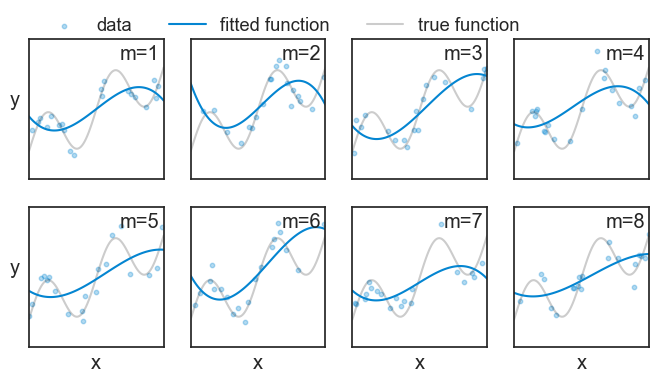

In [ ]:
#| code-summary: "plot 8 fitted functions from repeated experiments"
np.random.seed(0)
deg = 3          # degree of the fitted polynomial
sigma = 0.3      # standard deviation of the noise
M = 8          # number of repeated experiments
n_train = 20     # number of observed points used to fit in each experiment
fig, ax = plt.subplots(2, 4, figsize=(8, 4), sharex=True, sharey=True)
ax = ax.flatten()
for i in range(M):
    idx = np.random.choice(N, size=n_train, replace=False)
    noise = np.random.normal(0, sigma, size=n_train)
    x_m = x_grid[idx]
    y_m = f(x_m) + noise
    # fit with a numerically stable polynomial basis (chebyshev)
    p = Chebyshev.fit(x_m, y_m, deg, domain=[0, 1])
    l_true, = ax[i].plot(x_grid, f(x_grid), color='black', label='true function', alpha=0.2)
    l_data = ax[i].scatter(x_m, y_m, s=10, alpha=0.3, color=blue)
    l_fitted, = ax[i].plot(x_grid, p(x_grid), color=blue, label='fitted function')
    ax[i].text(0.97, 0.97, f"m={i+1}", transform=ax[i].transAxes,
            horizontalalignment='right', verticalalignment='top',)
    if i ==0:
        ax[i].legend([l_data, l_fitted, l_true],
          ["data", "fitted function", "true function"],
          loc="center left",
          bbox_to_anchor=(0.0,1.1),
          frameon=False, fancybox=False, shadow=False, ncol=3,)
    if i >= 4:
        ax[i].set(xlabel="x")
    if i % 4 == 0:
        ax[i].set_ylabel("y", rotation=0, labelpad=10)
    ax[i].set(xlim=(x_grid[0], x_grid[-1]),
              ylim=(-1, 4),
              xticks=[],
              yticks=[])

Note that in each experiment $m$ we observe a different set of data points, and therefore we get a different fitted function ${\hat{f}}_m(x)$. We will do the same for 200 experiments, and plot it as a "spaghetti plot":

In [ ]:
#| code-summary: "generate data for 200 repeated experiments, and fit each of them"
np.random.seed(0)
deg = 3          # degree of the fitted polynomial
sigma = 0.3      # standard deviation of the noise
M = 200          # number of repeated experiments
n_train = 20     # number of observed points used to fit in each experiment

# we'll store the predictions of all M fitted models on the full x_grid in this array
preds = np.empty((M, N))

for m in range(M):
    # choose which points are observed
    idx = np.random.choice(N, size=n_train, replace=False)
    # generate noisy observations at those points
    noise = np.random.normal(0, sigma, size=n_train)
    x_m = x_grid[idx]
    y_m = f(x_m) + noise
    # fit with a numerically stable polynomial basis (chebyshev)
    # we get a callable polynomial
    p = Chebyshev.fit(x_m, y_m, deg, domain=[0, 1])
    # evaluate the fitted model on the full grid (common x for averaging across fits)
    preds[m, :] = p(x_grid)

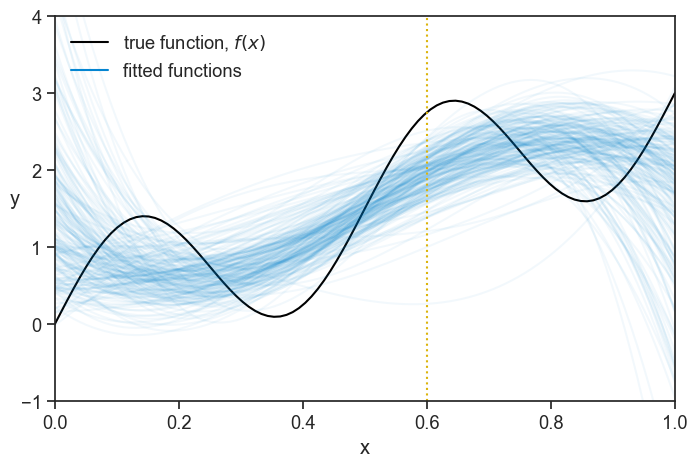

In [36]:
#| code-summary: "spaghetti plot of all 200 fitted functions"
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(x_grid, f(x_grid), color="black", label=r"true function, $f(x)$")
ax.plot([], [], color=blue, label="fitted functions")
for m in range(M):
    ax.plot(x_grid, preds[m, :], color=blue, alpha=0.05)
ax.axvline(x=0.6, color=gold, linestyle=":")
ax.legend(loc='upper left', frameon=False)
ax.set(xlim=(x_grid[0], x_grid[-1]),
       ylim=(-1, 4),
       xlabel="x",);
ax.set_ylabel("y", rotation=0);

A pattern seems to emerge!

Now, let's focus on a tiny slice of the graph, centered at $x=0.6$ (the vertical dotted line)

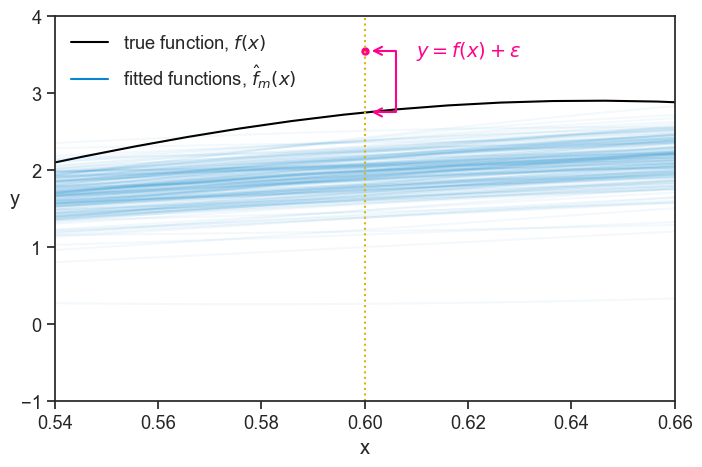

In [37]:
#| code-summary: "a thin slice"
fig, ax = plt.subplots(figsize=(8, 5))
test_point = [0.6, f(0.6)+0.8]
ax.plot(*test_point, ls="None", marker="o", markersize=5, mec=pink, mfc=pink)
ax.plot(x_grid, f(x_grid), color="black", label=r"true function, $f(x)$")
ax.annotate(
    "",
    xy=(0.6, f(0.6)),
    xytext=tuple(test_point),
    arrowprops=dict(arrowstyle="<->", color=pink, lw=1.5, connectionstyle="bar,fraction=-0.5",
                    shrinkA=5, shrinkB=5),
)
ax.text(test_point[0]+0.010, test_point[1], r"$y=f(x)+\epsilon$", color=pink, fontsize=14, ha="left", va="center")
ax.plot([], [], color=blue, label=r"fitted functions, $\hat{f}_m(x)$")
ax.legend(loc='upper left', frameon=False)
for m in range(M):
    ax.plot(x_grid, preds[m, :], color=blue, alpha=0.05)
ax.axvline(x=0.6, color=gold, linestyle=":")
ax.set(xlim=(0.54, 0.66),
       ylim=(-1, 4),
       xlabel="x",);
ax.set_ylabel("y", rotation=0);

The pink dot denotes a "test point". We can think of it as representing a future measurement at $x=0.6$ (another person interviewed that we know has $x=0.6$ years of education). Since we now have a bunch of fitted functions, we can ask how well do we **expect** them to predict the value of $y$ at $x=0.6$? Or, turning it around, how badly do we expect them to err the value of $y$ at $x=0.6$?
The error for a specific fitted function at a specific $x$ value is the vertical distance between it and the test point:

$$
\text{error} = \hat{f}_m(x) - y.
$$

The expected squared error over all repetitions of the experiment, that is, over all fitted functions, is:

$$
\mathbb{E}_D[(\hat{f}(x) - y)^2\mid x],
$$

where the symbols $|x$ mean "given $x$", meaning that we are looking at the error at a specific value of $x$. 

Note that:

* This error exists because each curve was fitted (trained) on a different random dataset $D$, and because of the noise $\epsilon$ in the test point.
* If we were to calculate the expected error without the square, positive and negative errors could cancel each other out, and we could get a low value even for a very bad model. By squaring the error, we make sure that all errors contribute positively to the expected error. More on that later.

## expected squared error

What follows is a derivation of the expected squared error. If you don't care about how we get to the formula, you can skip to the next section.

We start by substituting the value of $y=f(x)+\epsilon$ in the expected error:
$$
\mathbb{E}_D[(\hat{f}(x) - f(x) - \epsilon)^2\mid x].
$$

Let's call $A = \hat{f}(x) - f(x)$. Then the expected squared error becomes:

$$
\mathbb{E}_D[(A - \epsilon)^2\mid x].
$$

Expanding the square, we get:

\begin{align*}
\mathbb{E}_D[(A - \epsilon)^2\mid x] &= \mathbb{E}_D[A^2 - 2A\epsilon + \epsilon^2\mid x] \\
&= \underbrace{\mathbb{E}_D[A^2\mid x]}_{\text{term 1}} - 2\underbrace{\mathbb{E}_D[A\epsilon\mid x]}_{\text{term 2}} + \underbrace{\mathbb{E}_D[\epsilon^2\mid x]}_{\text{term 3}}.
\end{align*}

* **term 2:** the test noise $\epsilon$ is independent of the training dataset $D$, therefore independent of $\hat{f}(x)$ and of $A$. Remember also that we assumed that the noise has zero mean, so $\mathbb{E}[\epsilon] = 0$. Therefore:

    $$
    \mathbb{E}_D[A\epsilon\mid x] = \mathbb{E}_D[A\mid x]\cdot\mathbb{E}[\epsilon] = \mathbb{E}_D[A\mid x]\cdot 0 = 0.
    $$
* **term 3:** we can use the identity that for a random variable $\epsilon$ with finite variance,
    $$
    \mathbb{E}[\epsilon^2] = \text{Var}(\epsilon) + (\mathbb{E}[\epsilon])^2.
    $$
    Since we assumed that $\epsilon$ has zero mean, the last term is zero, and we get:
    $$
    \mathbb{E}_D[\epsilon^2\mid x] = \text{Var}(\epsilon) = \sigma^2.
    $$


Let's take stock of what we have so far. The expected error is now:

\begin{align*}
\mathbb{E}_D[(\hat{f}(x) - y)^2\mid x] &= \mathbb{E}_D[A^2\mid x] + \sigma^2 \\
&= \mathbb{E}_D[(\hat{f}(x) - f(x))^2\mid x] + \sigma^2.
\end{align*}

The first term is the error from the model $\hat{f}$ not matching the ground truth $f$, and the second term is an irreducible error from the noise in the data. Let's analyze the first term a bit more.

We define the mean predictor at $x$ to be:

$$
\mu(x) = \mathbb{E}_D[\hat{f}(x)\mid x].
$$

In the graph above, it would simply be the mean of all the 200 blue lines at a specific $x$ value.
Now let's perform a little trick: we add and subtract $\mu(x)$ inside the parenthesis in the first term:

$$
\hat{f}(x) - f(x) = \left(\hat{f}(x) - \mu(x)\right) + \Bigl(\mu(x) - f(x)\Bigr).
$$

Now squaring it:

$$
(\hat{f} - f)^2 = \left(\hat{f} - \mu\right)^2 + \Bigl(\mu - f\Bigr)^2 + 2\left(\hat{f} - \mu\right)\Bigl(\mu - f\Bigr).
$$

What we wanted to analyze is the expected value of this expression:

\begin{align*}
\mathbb{E}_D[(\hat{f} - f)^2\mid x] &=
\mathbb{E}_D\left[\left(\hat{f} - \mu\right)^2\mid x\right] \\
&+ \Bigl(\mu - f\Bigr)^2 \\
&+ 2\Bigl(\mu - f\Bigr)\mathbb{E}_D\left[\left(\hat{f} - \mu\right)\mid x\right]
\end{align*}

In the 2nd and 3rd terms, the term $(\mu - f)$ got out of the expectation operator $\mathbb{E}$ because it is a constant, not a random variable.
This expression looks complicated, but it can get simpler. Let's start with the last term. Since $\mu$ is the expected value of $\hat{f}$, we have:

$$
\mathbb{E}_D\left[\left(\hat{f} - \mu\right)\mid x\right] = \mathbb{E}_D\left[\hat{f}\mid x\right] - \mu = \mu - \mu = 0.
$$

The very last thing we do now it to give names to the first two terms. The first term is called the **variance** of the model,

$$
\text{Var}\left[\hat{f}(x)\right] = \mathbb{E}_D\left[\left(\hat{f}(x) - \mu(x)\right)^2\mid x\right],
$$

and the second term is the square of the **bias** of the model,

$$
\text{Bias}^2\left[\hat{f}(x)\right] = \Bigl(\mu(x) - f(x)\Bigr)^2.
$$

## bias–variance–noise decomposition

Putting everything together, we get the following decomposition of the expected squared error:

$$
\mathbb{E}_D[(\hat{f}(x) - y)^2\mid x] = \text{Var}\left[\hat{f}(x)\right] + \text{Bias}^2\left[\hat{f}(x)\right] + \sigma^2.
$$

We did all this hard work of deriving this decomposition to understand the different sources of error in our model. Hopefully, a good model will give a low expected error. Let's see a few examples of repeated experiments, this time for polynomials of degree 3, 6, and 11.

In [38]:
#| code-summary: "calculate mean and std for all degrees from 1 to 15"
np.random.seed(0)
degree_max = 15  # degree of the fitted polynomial
sigma = 0.3      # standard deviation of the noise
M = 200          # number of repeated experiments
n_train = 20     # number of observed points used to fit in each experiment

# we'll store the predictions of all M fitted models on the full x_grid in this array
preds15 = np.empty((M, N, degree_max))

for deg in range(1, degree_max+1):

    for m in range(M):
        # generate a new noisy realization of the data on the fixed grid
        noise = np.random.normal(0, sigma, size=N)
        y = f(x_grid) + noise

        # choose which n_train grid points are "observed" in this experiment
        idx = np.random.choice(N, size=n_train, replace=False)

        # # fit a degree-deg polynomial to the observed points
        # coeffs = np.polyfit(x_grid[idx], y[idx], deg)

        # # turn the fitted coefficients into a callable polynomial
        # p = np.poly1d(coeffs)
        # fit with a numerically stable polynomial basis (chebyshev)
        # we get a callable polynomial
        p = Chebyshev.fit(x_grid[idx], y[idx], deg, domain=[0, 1])

        # evaluate the fitted model on the full grid (common x for averaging across fits)
        preds15[m, :, deg-1] = p(x_grid)

# calculate the mean prediction and its standard deviation across the M fitted models, for every point on the x-grid
mean_pred = preds15.mean(axis=0)
std_pred  = preds15.std(axis=0)

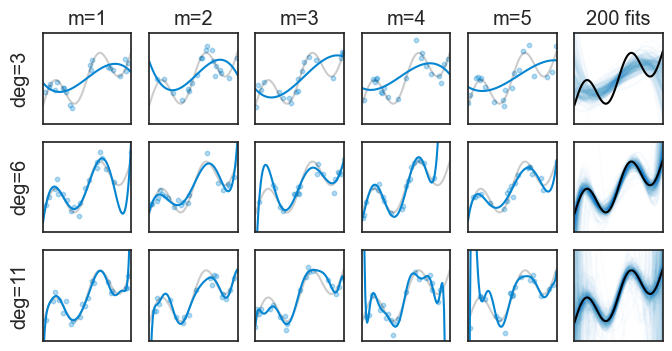

In [39]:
#| code-summary: "plot 8 fitted functions from repeated experiments"
np.random.seed(0)
degr = [3, 6, 11] # list of degrees to fit
sigma = 0.3      # standard deviation of the noise
M5 = 5          # number of repeated experiments
n_train = 20     # number of observed points used to fit in each experiment
fig, ax = plt.subplots(3, 6, figsize=(8, 4), sharex=True, sharey=True)
for d, deg in enumerate(degr):
    ax[d,0].set_ylabel(f"deg={deg}", labelpad=10)
    for m in range(M):
        ax[d, 5].plot(x_grid, preds15[m, :, deg-1], color=blue, alpha=0.02)
        if d ==0:
            ax[d, 5].set_title(f"200 fits")
    ax[d, 5].plot(x_grid, f(x_grid), color='black', label='true function', alpha=1)
    for i in range(M5):
        idx = np.random.choice(N, size=n_train, replace=False)
        noise = np.random.normal(0, sigma, size=n_train)
        x_m = x_grid[idx]
        y_m = f(x_m) + noise
        p = Chebyshev.fit(x_m, y_m, deg, domain=[0, 1])
        l_true, = ax[d, i].plot(x_grid, f(x_grid), color='black', label='true function', alpha=0.2)
        l_data = ax[d, i].scatter(x_m, y_m, s=10, alpha=0.3, color=blue)
        l_fitted, = ax[d, i].plot(x_grid, p(x_grid), color=blue, label='fitted function')
        if d ==0:
            ax[0,i].set_title(f"m={i+1}")
        ax[d, i].set(xlim=(x_grid[0], x_grid[-1]),
                ylim=(-1, 4),
                xticks=[],
                yticks=[])

In the top row we fitted a 3rd degree polynomial. None of the five examples does a great job at approximating the true function, and this is quantified by their high bias. On the other hand, at least they are all pretty similar to each other. Remember: each repeated experiment drew a different set of data points, but all 3rd order polynomials are still pretty similar to each other. This is quantified by their low variance. The last plot on the right shows 200 fitted functions, and we can see that they are all pretty similar to each other (the spaghetti is not too messy), but the overall shape in the aggregate is far from the true black curve.

The bottom row shows the opposite. The 11th degree polynomials are very flexible, and they can approximate the true function very well, which is quantified by their low bias. However, this flexibility comes at a cost: the fitted functions are very different from each other, and this is quantified by their high variance.
Here, the spaghetti plot on the right is very messy, and the aggregate of all fitted functions is very close to the true function.

<div class="alert alert-danger">
High bias: We can understand that high bias means that a model is not flexible enough to capture the true function, and therefore it is systematically wrong in its predictions.

High variance: We can understand that high variance means that a model is highly sensitive to the specific data points it was trained on. If we were to train the same model on a different dataset, we would get a very different fitted function.</div>

Instead of showing spaghetti plots, we can compute the mean and standard deviation of all repeated experiments. It the plot below, the mean is the blue line, and the shaded area represents ±1 standard deviation.

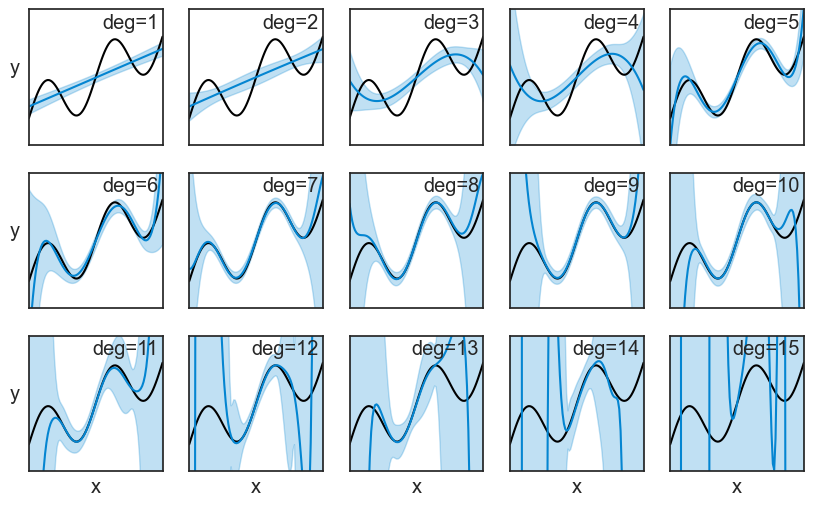

In [40]:
#| code-summary: "plot results for all degrees from 1 to 15"
fig, ax = plt.subplots(3, 5, figsize=(10, 6), sharex=True, sharey=True)
ax = ax.flatten()
for i in range(15):
    ax[i].plot(x_grid, f(x_grid), color="black", label="true function")
    ax[i].plot(x_grid, mean_pred[:, i], label=f"mean prediction (deg={i+1})", color=blue)
    ax[i].fill_between(x_grid, mean_pred[:, i] - std_pred[:, i], mean_pred[:, i] + std_pred[:, i], alpha=0.25, label="±1 std", color=blue)

    ax[i].text(0.97, 0.97, f"deg={i+1}", transform=ax[i].transAxes,
            horizontalalignment='right', verticalalignment='top',)
    if i >= 10:
        ax[i].set(xlabel="x")
    if i % 5 == 0:
        ax[i].set_ylabel("y", rotation=0, labelpad=10)
    ax[i].set(xlim=(x_grid[0], x_grid[-1]),
              ylim=(-1, 4),
              xticks=[],
              yticks=[])


We can actually see the bias and variance in these plots. To make it more clear, let's focus on two polynomials: the 3rd degree and the 8th degree. The bias squared and the variance, shown in the middle and right columns, are just the square of the distances marked on the left column.

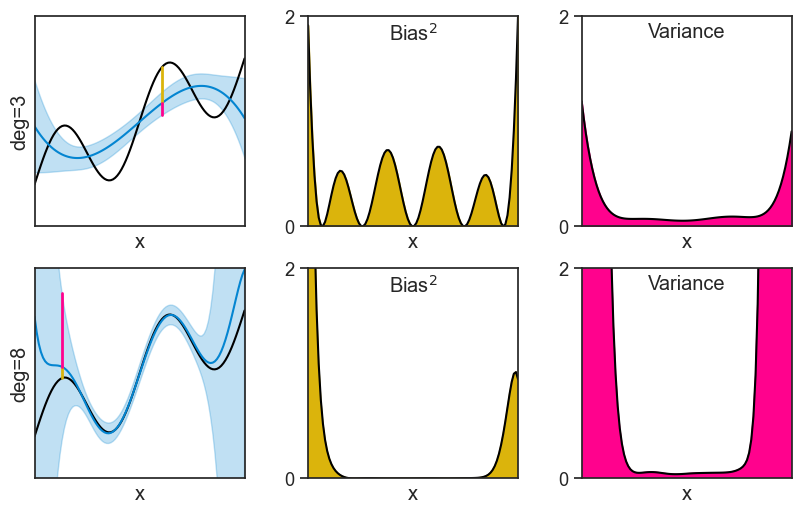

In [41]:
#| code-summary: "bias-variance decomposition for deg=3 and deg=8"
fig, ax = plt.subplots(2, 3, figsize=(10, 6))

deg_A = 3
ax[0,0].plot(x_grid, f(x_grid), color="black", label="true function")
ax[0,0].plot(x_grid, mean_pred[:, deg_A-1], label=f"mean prediction (deg={deg_A})", color=blue)
ax[0,0].fill_between(x_grid, mean_pred[:, deg_A-1] - std_pred[:, deg_A-1], mean_pred[:, deg_A-1] + std_pred[:, deg_A-1], alpha=0.25, label="±1 std", color=blue)
ax[0,0].set_box_aspect(1)
ax[0,0].set(xlim=(x_grid[0], x_grid[-1]),
        ylim=(-1, 4),
        xticks=[],
        yticks=[],
        xlabel="x",
        ylabel="deg=3")
idx = int(0.6 * len(x_grid))
ax[0,0].plot([x_grid[idx]]*2, [f(x_grid[idx]), mean_pred[idx, deg_A-1]], color=gold, lw=2)
ax[0,0].plot([x_grid[idx]]*2, [mean_pred[idx, deg_A-1], mean_pred[idx, deg_A-1]-std_pred[idx, deg_A-1]], color=pink, lw=2)

ax[0,1].plot(x_grid, (f(x_grid)-mean_pred[:, deg_A-1])**2, color="black", label="true function")
ax[0,1].fill_between(x_grid, 0, (f(x_grid)-mean_pred[:, deg_A-1])**2, color=gold, label="bias^2")
ax[0,2].plot(x_grid, (std_pred[:, deg_A-1])**2, color="black", label="true function")
ax[0,2].fill_between(x_grid, 0, (std_pred[:, deg_A-1])**2, color=pink, label="variance")
ax[0,1].set_box_aspect(1)
ax[0,2].set_box_aspect(1)
ax[0,1].set(xlim=(x_grid[0], x_grid[-1]),
        ylim=(0, 2),
        xticks=[],
        xlabel="x",
        yticks=[0,2])
ax[0,2].set(xlim=(x_grid[0], x_grid[-1]),
        ylim=(0, 2),
        xticks=[],
        xlabel="x",
        yticks=[0,2])

ax[0,1].text(0.5, 0.97, r"Bias$^2$", transform=ax[0,1].transAxes,
         horizontalalignment='center', verticalalignment='top',)
ax[0,2].text(0.5, 0.97, r"Variance", transform=ax[0,2].transAxes,
         horizontalalignment='center', verticalalignment='top',)



###

deg_B = 8
ax[1,0].plot(x_grid, f(x_grid), color="black", label="true function")
ax[1,0].plot(x_grid, mean_pred[:, deg_B-1], label=f"mean prediction (deg={deg_B})", color=blue)
ax[1,0].fill_between(x_grid, mean_pred[:, deg_B-1] - std_pred[:, deg_B-1], mean_pred[:, deg_B-1] + std_pred[:, deg_B-1], alpha=0.25, label="±1 std", color=blue)
ax[1,0].set_box_aspect(1)
ax[1,0].set(xlim=(x_grid[0], x_grid[-1]),
        ylim=(-1, 4),
        xticks=[],
        yticks=[],
        xlabel="x",
        ylabel="deg=8")
idx = int(0.13 * len(x_grid))
ax[1,0].plot([x_grid[idx]]*2, [f(x_grid[idx]), mean_pred[idx, deg_B-1]], color=gold, lw=2)
ax[1,0].plot([x_grid[idx]]*2, [mean_pred[idx, deg_B-1], mean_pred[idx, deg_B-1]+std_pred[idx, deg_B-1]], color=pink, lw=2)

ax[1,1].plot(x_grid, (f(x_grid)-mean_pred[:, deg_B-1])**2, color="black", label="true function")
ax[1,1].fill_between(x_grid, 0, (f(x_grid)-mean_pred[:, deg_B-1])**2, color=gold, label="bias^2")
ax[1,2].plot(x_grid, (std_pred[:, deg_B-1])**2, color="black", label="true function")
ax[1,2].fill_between(x_grid, 0, (std_pred[:, deg_B-1])**2, color=pink, label="variance")
ax[1,1].set_box_aspect(1)
ax[1,2].set_box_aspect(1)
ax[1,1].set(xlim=(x_grid[0], x_grid[-1]),
        ylim=(0, 2),
        xticks=[],
        xlabel="x",
        yticks=[0,2])
ax[1,2].set(xlim=(x_grid[0], x_grid[-1]),
        ylim=(0, 2),
        xticks=[],
        xlabel="x",
        yticks=[0,2])

ax[1,1].text(0.5, 0.97, r"Bias$^2$", transform=ax[1,1].transAxes,
         horizontalalignment='center', verticalalignment='top',)
ax[1,2].text(0.5, 0.97, r"Variance", transform=ax[1,2].transAxes,
         horizontalalignment='center', verticalalignment='top',);

## tradeoff

We quantified the bias and the variance at every specific value of $x$. It makes sense to ask: if we aggregate the bias and the variance across all $x$ values, can we get a single number that quantifies the overall bias and variance of the model? In mathematical terms, we can take the expected value of the squared error across all $x$ values:

\begin{align*}
\mathbb{E}_x\left[\mathbb{E}_D[(\hat{f}(x) - y)^2\mid x]\right] &= \mathbb{E}_x\left[\text{Var}\left[\hat{f}(x)\right]\right] \\
&+ \mathbb{E}_x\left[\text{Bias}^2\left[\hat{f}(x)\right]\right]\\
&+ \sigma^2
\end{align*}

Once more the noise term gets out of the expectation operator because it is a constant, not a random variable. The actual calculation that we execute with $\mathbb{E}_x$ requires us to specify a distribution over $x$ values. See three possible choices:

1. We can assume that $x$ is uniformly distributed in the interval $[0, 1]$. This means that we are equally interested in all $x$ values between 0 and 1, and we want to give them equal weight when calculating the overall bias and variance. In our concrete example, this would mean that all levels of education between 0 and 1 are equally important to us, and we want to give them equal weight when calculating the overall bias and variance of our model. This is a common choice in theoretical analyses, but it may not always be the most realistic one.
2. We can assume that $x$ is distributed according to the distribution of the data points that we actually observed in the dataset. The "empirical distribution" of the data points gives more weight to $x$ values that are more common in the observed data, and less weight to $x$ values that are less common. For instance, our dataset may have more people with an education level lower than 0.2 than people with an education level higher than 0.8, so it wouldn't make sense to give them equal weight when calculating the overall bias and variance.
3. We might know the true distribution of $x$ in the population, and use it to calculate the overall bias and variance. In our example, we might have access to census data that tells us the distribution of education levels in the population, and we can use this information to calculate the overall bias and variance of our model.

For simplicity's sake, let's assume that $x$ is uniformly distributed in the interval $[0, 1]$. See how the overall bias and variance change as we increase the degree of the polynomial.

In [12]:
#| code-summary: "compute overall bias and variance"

p_order = np.arange(1, 9)
bias2 = np.empty(len(p_order))
var = np.empty(len(p_order))
for i, deg in enumerate(p_order):
    bias2[i] = np.mean((f(x_grid) - mean_pred[:, deg-1])**2)
    var[i] = np.mean(std_pred[:, deg-1]**2)

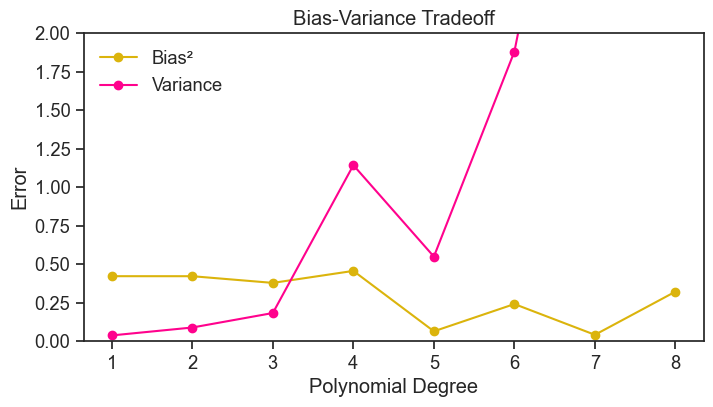

In [ ]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(p_order, bias2, label="Bias²", marker='o', color=gold)
ax.plot(p_order, var, label="Variance", marker='o', color=pink)
ax.set(xlabel="Polynomial Degree",
       ylabel="Error",
       xticks=p_order,
       title="Bias-Variance Tradeoff",
       ylim=(0, 2));
ax.legend(loc='upper left', frameon=False);

In broad terms, and for fixed data size and noise level, increasing the degree of the polynomial tends to decrease the bias and increase the variance. This is what we call the **bias-variance tradeoff**. A model with low bias and low variance would be ideal, but with finite data these two goals are typically in tension. Increasing model complexity can reduce bias, but often at the cost of increased variance; decreasing complexity has the opposite effect.

The curves above are quite jagged, and we do not observe a smooth monotonic decrease in bias or increase in variance. This is partly because we are estimating bias and variance from a finite number of repeated experiments. To reduce this Monte Carlo noise and make the underlying trends clearer, we repeat the analysis below using 5000 experiments instead of 200, and sampling 50 data points per experiment instead of 20.

In [ ]:
#| code-summary: "compute overall bias and variance for all degrees from 1 to 15"
# setup
np.random.seed(0)
N = 100
x_grid = np.linspace(0, 1, N)
f = lambda x: np.sin(4*np.pi*x) + 3*x

sigma = 0.3
M = 5000
n_train = 50
degrees = np.arange(1, 13)

# pre-generate randomness once (shared across all degrees)
noise_mat = np.random.normal(0, sigma, size=(M, N))
idx_mat = np.array([np.random.choice(N, size=n_train, replace=False) for _ in range(M)])

bias2_list = []
var_list = []

for deg in degrees:
    preds = np.empty((M, N))

    for m in range(M):
        # generate dataset m (same x_grid, new noise)
        y = f(x_grid) + noise_mat[m]

        # observe subset for training
        idx = idx_mat[m]

        # fit with a numerically stable polynomial basis (chebyshev)
        p = Chebyshev.fit(x_grid[idx], y[idx], deg, domain=[0, 1])

        # evaluate on the common grid
        preds[m] = p(x_grid)

    mean_pred = preds.mean(axis=0)
    std_pred = preds.std(axis=0)

    # bias^2 and variance aggregated over x
    bias2_list.append(np.mean((mean_pred - f(x_grid))**2))
    var_list.append(np.mean(std_pred**2))

bias2_arr = np.array(bias2_list)
var_arr = np.array(var_list)

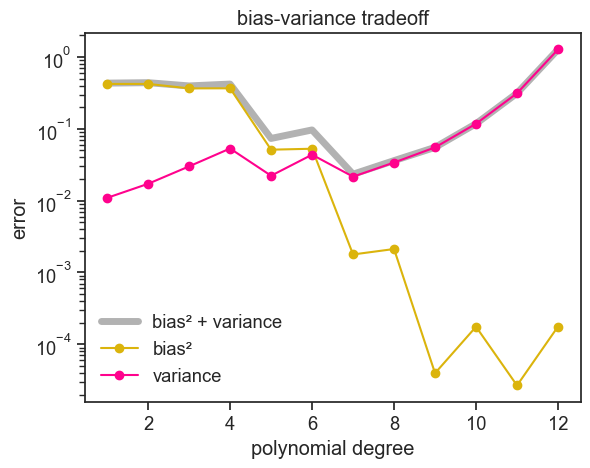

In [43]:
#| code-summary: "plot tradeoff"
fig, ax = plt.subplots()
ax.plot(degrees, bias2_arr + var_arr, lw=5, alpha=0.3, label="bias² + variance", color='black')
ax.plot(degrees, bias2_arr, marker="o", label="bias²", color=gold)
ax.plot(degrees, var_arr, marker="o", label="variance", color=pink)
ax.set(xlabel="polynomial degree", ylabel="error", title="bias-variance tradeoff")
ax.set_yscale("log")
ax.legend(frameon=False);

If our aim is to minimize the expected error, we should choose a polynomial degree that minimizes the sum of bias and variance. In the plot above, the sweet spot of the bias-variance tradeoff for this specific problem is around a degree of 7.